---
date: 2021-07-05
tags:
- python
---


# Book info using python

I want to post my book reviews to this here blog, and to keep it simple, have a script pull up relevant book info. So this here is a exploration of how to to do.


sample book: [The Uninhabitable Earth](https://www.google.com.au/books/edition/The_Uninhabitable_Earth/rNNtDwAAQBAJ?hl=en&gbpv=0)

First up, there are a number of ways to get book info. So trying out a few.

In [1]:
isbn = 9780141988870 # testing isbn number

## isbnlib

This seems a reasonably popular isbn lib:
https://github.com/xlcnd/isbnlib

`pip install isbnlib`

isbnlib grabs info from google books by default.


In [73]:
from isbnlib import meta, cover

print(cover(str(isbn)))
meta(str(isbn))

{'smallThumbnail': 'http://books.google.com/books/content?id=248DyAEACAAJ&printsec=frontcover&img=1&zoom=5&source=gbs_api', 'thumbnail': 'http://books.google.com/books/content?id=248DyAEACAAJ&printsec=frontcover&img=1&zoom=1&source=gbs_api'}


{'ISBN-13': '9780141988870',
 'Title': 'The Uninhabitable Earth - A Story of the Future',
 'Authors': ['David Wallace-Wells'],
 'Publisher': '',
 'Year': '2019',
 'Language': 'un'}

hmmm... this is so simple that I might as well try this directly.

## Google books

Trying out Google books directly

In [7]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

In [76]:
def get_book_info(isbn: int):
    api = "https://www.googleapis.com/books/v1/volumes?q=isbn:"
    response = requests.get(f"{api}{isbn}")
    
    # return the first item
    if response:
        all_data = response.json()["items"][0]
    else:
        return False

    return all_data["volumeInfo"]
    #img_url = all_data["volumeInfo"]["imageLinks"]["thumbnail"]
    
data = get_book_info(isbn)
data

{'title': 'The Uninhabitable Earth',
 'subtitle': 'A Story of the Future',
 'authors': ['David Wallace-Wells'],
 'publishedDate': '2019-09-05',
 'description': '**SUNDAY TIMES AND THE NEW YORK TIMES BESTSELLER** \'An epoch-defining book\' Matt Haig \'If you read just one work of non-fiction this year, it should probably be this\' David Sexton, Evening Standard Selected as a Book of the Year 2019 by the Sunday Times, Spectator and New Statesman A Waterstones Paperback of the Year and shortlisted for the Foyles Book of the Year 2019 Longlisted for the PEN / E.O. Wilson Literary Science Writing Award It is worse, much worse, than you think. The slowness of climate change is a fairy tale, perhaps as pernicious as the one that says it isn\'t happening at all, and if your anxiety about it is dominated by fears of sea-level rise, you are barely scratching the surface of what terrors are possible, even within the lifetime of a teenager today. Over the past decades, the term "Anthropocene" has 

Now to get the image cover:

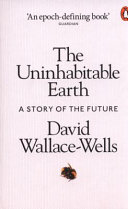

In [78]:
def get_image(url: str, path=None):
    """downloads image and returns it
    todo: save to disk if given a filepath"""
    
    r = requests.get(url)
    img = Image.open(BytesIO(r.content))
    
    if path:
        print("save to disk here")
    
    return img

get_image(data["imageLinks"]["thumbnail"])

## Goodreads

Now this is the service I actually want to use, but sadly Goodreads [removed](https://help.goodreads.com/s/article/Does-Goodreads-support-the-use-of-APIs) their [api](https://www.goodreads.com/api) and shows no sign of bringing one back.

So one option is to scape goodreads. I set my prfofile visible to the world, got some url's and...

First trying out pandas to get the reviews table:

In [8]:
from bs4 import BeautifulSoup
from dataclasses import dataclass
import pandas as pd

@dataclass
class gr:
    "stores goodreads urls"
    user = "https://www.goodreads.com/user/show/819075-ko"
    reviews = "https://www.goodreads.com/review/list/819075-ko?order=d&sort=review&view=reviews"
    ratings = "https://www.goodreads.com/review/list/819075-ko?sort=rating&view=reviews"


In [59]:
df = pd.read_html(gr.reviews)[1]
df = df[df.columns[2:-1]] # drop unnecessary cols
print(df.shape)
df.iloc[0]

(30, 8)


title                                title Freedom at Midnight
author                                   author Collins, Larry
rating                                         avg rating 4.32
rating.1                          KO's rating  did not like it
my rating    my rating  1 of 5 stars2 of 5 stars3 of 5 star...
review       review  Oh goody, yet another book written thr...
read                                        date read  not set
added                                 date added  May 28, 2013
Name: 0, dtype: object

Pandas doesn't do a great job with the table, so moving on to [beautiful soup](https://www.crummy.com/software/BeautifulSoup/)

In [75]:
r = requests.get(gr.reviews)
soup = BeautifulSoup(r.content, 'html.parser')

In [78]:
tables = soup.find_all("table")

In [87]:
df = pd.read_html(tables[1].prettify())[0]
df.head()

,Unnamed: 0,cover,title,author,rating,rating.1,my rating,review,read,added,Unnamed: 10
0,checkbox,cover,title Freedom at Midnight,"author Collins, Larry",avg rating 4.32,KO's rating did not like it,my rating 1 of 5 stars 2 of 5 stars 3 of 5 ...,"review Oh goody, yet another book written thr...",date read not set,"date added May 28, 2013",actions view
1,checkbox,cover,title Terra Nullius: A Journey Through No One...,"author Lindqvist, Sven",avg rating 4.03,KO's rating it was amazing,my rating 1 of 5 stars 2 of 5 stars 3 of 5 ...,"review A great starting point on Australia, r...","date read Aug 27, 2012","date added Aug 23, 2012",actions view
2,checkbox,cover,title Pakistan: A Hard Country,"author Lieven, Anatol",avg rating 4.09,KO's rating liked it,my rating 1 of 5 stars 2 of 5 stars 3 of 5 ...,"review Gets some stuff right, a lot right, bu...",date read not set,"date added May 01, 2011",actions view
3,checkbox,cover,title Shameful Flight: The Last Years of the ...,"author Wolpert, Stanley",avg rating 4.00,KO's rating it was amazing,my rating 1 of 5 stars 2 of 5 stars 3 of 5 ...,"review Best, most concise history of the inde...","date read Mar 02, 2010","date added Mar 01, 2010",actions view
4,checkbox,cover,"title Tiamat's Wrath (The Expanse, #8)","author Corey, James S.A. *",avg rating 4.56,KO's rating liked it,my rating 1 of 5 stars 2 of 5 stars 3 of 5 ...,"review Eight books into the series, it's done...",date read not set,"date added Mar 16, 2019",actions view


In [91]:
df.iloc[0]

Unnamed: 0                                              checkbox
cover                                                      cover
title                                 title  Freedom at Midnight
author                                    author  Collins, Larry
rating                                          avg rating  4.32
rating.1                            KO's rating  did not like it
my rating      my rating  1 of 5 stars  2 of 5 stars  3 of 5 ...
review         review  Oh goody, yet another book written thr...
read                                          date read  not set
added                                   date added  May 28, 2013
Unnamed: 10                                        actions  view
Name: 0, dtype: object

When I look at the source code in the web browser I can see that the entire review is in the table, as well as links to the cover img... so to capture this I need might need a js enabled scraper.

## Scrapy and Selenium

look at:

- https://github.com/OmarEinea/GoodReadsScraper

Using the beta version as the non-beta was last updated in 2018:

Conda doesn't seem to have the beta version so using pip:
`pip install selenium==4.0.0.b4` 

To get the webdriver to run, check the version of chrome installed and install the [same version of the chromedriver](https://chromedriver.chromium.org/downloads).

`pip install "chromedriver_binary==91.0.4472.101"`

If above doesn't work, try the auto binary:
`pip install chromedriver-binary-auto` # install the correct version

If chrome is updated, reinstall by
`pip install --upgrade --force-reinstall chromedriver-binary-auto`

The main table I want has the css id **books** and class **table stacked** and it lazy loads as I scroll down.

In [19]:
from selenium import webdriver
from selenium.webdriver.common.by import By

import chromedriver_binary  # Adds chromedriver binary to path

In [5]:
driver = webdriver.Chrome()
driver.get("http://www.python.org")
assert "Python" in driver.title

So the basics work, now moving on to using it for goodreads

In [21]:
driver = webdriver.Chrome()
driver.get(gr.reviews)
driver.title

'KO’s books on Goodreads (1,135 books)'

Ok need to come back to this later...

In [26]:
driver.close() # shut the browser when done